과제 내용 : 기계 독해 (LSTM 기반 영영화 긍/부정 결과 데이터셋 결과 기반 예측.)


#Mission! : 

vocab tockenizer, batch 크기 등과 

LSTM 모델의 하이퍼파라미터를 튜닝해서 최대한 

Accuracy를 올려보세요!

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
import torch
import torch.nn as nn
import urllib.request
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

데이터 깃헙에서 받아주겠습니다. 대표적인 영어데이터인 IMDB 리뷰데이터입니다.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7f6e2b0c1640>)

In [ ]:
df = pd.read_csv('IMDb_Reviews.csv', encoding='utf-8')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


첫 열은 영화 리뷰로, 둘째 열은 긍정/부정을 나타내는 열입니다. (긍정 1 부정 0)

In [ ]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


샘플 개수 50000개, 4 대 1 로 나눠주겠습니다.

In [ ]:
train_datapipe = df[:40000]
test_datapipe = df[40000:]

여러분의 커스텀 데이터셋을 만들어보세요. 아래 있는 코드를 쓰셔도 좋고 개별 구글링 진행하셔도 좋습니다.

https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

Create a custom Dataset class

In [ ]:
class CustomTextDataset(Dataset):
    def __init__(self, txt, labels):
        self.labels = labels
        self.text = text
def __len__(self):
        return len(self.labels)
def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        sample = {"Text": text, "Class": label}
        return sample

Initialise the CustomTextDataset class


In [ ]:
import numpy as np

In [ ]:
# define data and class labels
text = train_datapipe.review
labels = train_datapipe.sentiment

# DataLoader
(dataset, batch_size=1, shuffle=False, sampler=None,  batch_sampler=None, num_workers=0, collate_fn=None,
pin_memory=False, drop_last=False, timeout=0,
worker_init_fn=None)

In [ ]:
# Import libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# create custom dataset class
class CustomTextDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.text[idx]
        sample = (label, data)
        return sample

# define data and class labels
text = text
labels = labels

# create Pandas DataFrame
text_labels_df = pd.DataFrame({'Text': text, 'Labels': labels})

# define data set object
TD = CustomTextDataset(text_labels_df['Text'], text_labels_df['Labels'])

# Display image and label.
print('\nFirst iteration of data set: ', next(iter(TD)), '\n')

# Print how many items are in the data set
print('Length of data set: ', len(TD), '\n')

# Print entire data set
print('Entire data set: ', list(DataLoader(TD)), '\n')






First iteration of data set:  (1, 'My family and I normally do not watch local movies for the simple reason that they are poorly made, they lack the depth, and just not worth our time.<br /><br />The trailer of "Nasaan ka man" caught my attention, my daughter in law\'s and daughter\'s so we took time out to watch it this afternoon. The movie exceeded our expectations. The cinematography was very good, the story beautiful and the acting awesome. Jericho Rosales was really very good, so\'s Claudine Barretto. The fact that I despised Diether Ocampo proves he was effective at his role. I have never been this touched, moved and affected by a local movie before. Imagine a cynic like me dabbing my eyes at the end of the movie? Congratulations to Star Cinema!! Way to go, Jericho and Claudine!!') 

Length of data set:  40000 

Entire data set:  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


vocab tockenizer 설명 코랩랩

https://colab.research.google.com/github/PyTorchKorea/tutorials-kr/blob/master/docs/_downloads/b5fa995b1432ebc93ea7bfe7ec9daed1/text_sentiment_ngrams_tutorial.ipynb#scrollTo=qUEEK7gmuxuC

# LSTM 모델 구성

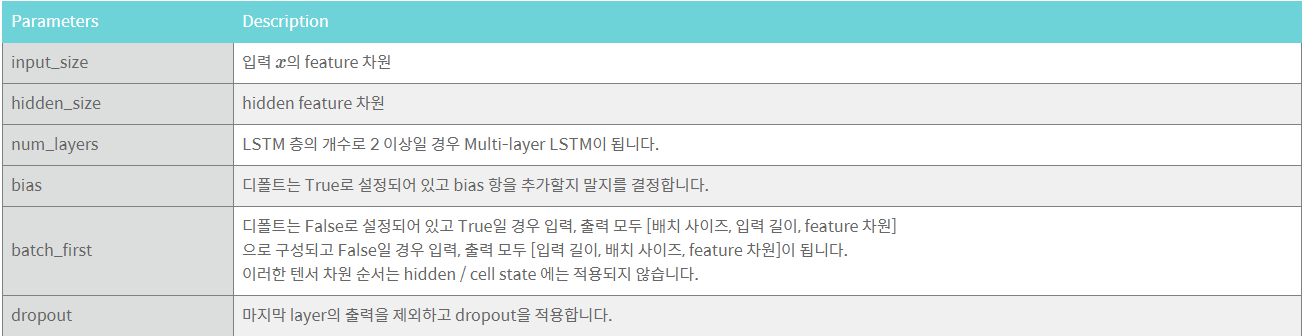

In [ ]:
class BasicLSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):
        super(BasicLSTM, self).__init__()
        print("Building Basic LSTM model...")

        
        self.n_layers = n_layers 
        #n_vocab : Vocab 안에 있는 단어의 개수, embed_dim : 임베딩 된 단어 텐서가 갖는 차원 값(dimension)
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
#---------------------------------------------- 여기 밑부터 작성해주세요~-------------------------------------------------
        #앞에서 정의한 하이퍼 파라미터를 넣어 LSTM 정의
        self.lstm = nn.LSTM(input_size=embed_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.n_layers,
                            batch_first=True)
        
        #Input: LSTM의 hidden state vector(context), Output : Class probability vector
        self.out = nn.Linear(self.hidden_dim, n_classes)
#----------------------------------------------여기까지-------------------------------------------------

    def forward(self, x):
        # Input data: 한 batch 내 모든 영화 평가 데이터
        
        x = self.embed(x)# 영화 평 임베딩

        # 초기 hidden, cell state vector를 zero vector로 생성
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
#------------------------------------------------여기 밑부터 작성해주세요-------------------------------------------------------------
        output, (h_t, c_t) = self.lstm(x, (h_0, c_0)) 
        #print(h_t.shape)
        #(1,64,h) ==> 64 batch-size,  h hidden_dimmension

        # 영화 리뷰 배열들을 압축한 hidden state vector
        # (batch_size, hidden_dim)형태의 텐서 추출
        h_t = h_t.view(-1, self.hidden_dim)

#-------------------------------------------------여기까지---------------------------------------------------------
        # linear layer의 입력으로 주고, 각 클래스 별 결과 logit을 생성.
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit


In [ ]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        optimizer.zero_grad()# 매번 기울기를 새로 계산하기 위해서 zero 로 초기화
        logit = model(x)#모델의 예측값 logit 계산
        #print(y)
        loss = F.cross_entropy(logit, y)# logit과 실제 label간의 오차를 구하고 기울기 계산
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate(model, val_iter):
    """evaluate model"""                   
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:# Validation 데이터셋에 대하여 
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    #전체 validation 셋에 대한 평균 loss와 accuracy를 구하는 과정
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

참고 : __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):

In [ ]:
n_layers = 1
hidden_dim = 32
vocab_size = len(text)
embed_dim = 128
n_classes = 3

Ir = 0.001
batch_size = 20

In [ ]:
model = BasicLSTM(1, 32, vocab_size, 128, n_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Building Basic LSTM model...


In [ ]:
model

BasicLSTM(
  (embed): Embedding(40000, 128)
  (lstm): LSTM(128, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
)

In [47]:
best_val_loss = None
EPOCHS = 1

for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

NameError: ignored

In [ ]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

FileNotFoundError: ignored